In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-alpha0
sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
matplotlib 3.0.3
numpy 1.16.2
pandas 0.24.2
sklearn 0.20.3
tensorflow 2.0.0-alpha0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
# https://storage.googleapis.com/tf-datasets/titanic/train.csv
# https://storage.googleapis.com/tf-datasets/titanic/eval.csv
train_file = "./data/titanic/train.csv"
eval_file = "./data/titanic/eval.csv"

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

print(train_df.head())
print(eval_df.head())

   survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
   survived     sex   age  n_siblings_spouses  parch     fare   class  \
0         0    male  35.0                   0      0   8.0500   Third   
1         0    male  54.0                   0      0  51.8625   First   
2         1  female  58.0                   0      0  26.5500   First   
3         1  female  55.0                   0      0  16.0000  Second   
4         

In [3]:
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

print(train_df.head())
print(eval_df.head())
print(y_train.head())
print(y_eval.head())

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
      sex   age  n_siblings_spouses  parch     fare   class     deck  \
0    male  35.0                   0      0   8.0500   Third  unknown   
1    male  54.0                   0      0  51.8625   First        E   
2  female  58.0                   0      0  26.5500   First        C   
3  female  55.0                   0      0  16.0000  Second  unknown   
4    male  34.0                   0      0  13.0000  Second        D   

  

In [4]:
train_df.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [5]:
print(train_df.shape, eval_df.shape)

(627, 9) (264, 9)


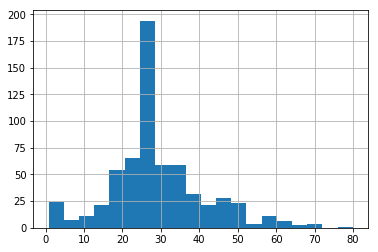

In [6]:
train_df.age.hist(bins = 20)

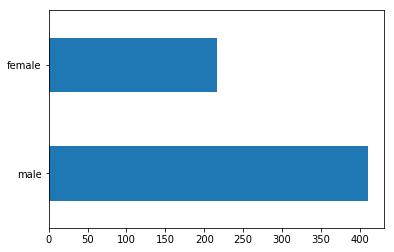

In [7]:
train_df.sex.value_counts().plot(kind = 'barh')

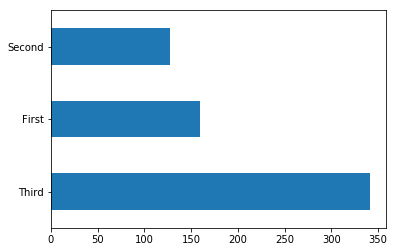

In [8]:
train_df['class'].value_counts().plot(kind = 'barh')

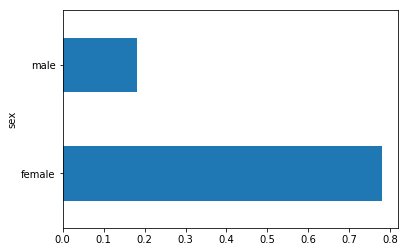

In [9]:
pd.concat([train_df, y_train], axis = 1).groupby('sex').survived.mean().plot(kind='barh')

In [10]:
categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class',
                       'deck', 'embark_town', 'alone']
numeric_columns = ['age', 'fare']

feature_columns = []
for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique()
    print(categorical_column, vocab)
    feature_columns.append(
        tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(
                categorical_column, vocab)))

for categorical_column in numeric_columns:
    feature_columns.append(
        tf.feature_column.numeric_column(
            categorical_column, dtype=tf.float32))

sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


In [11]:
def make_dataset(data_df, label_df, epochs = 10, shuffle = True,
                 batch_size = 32):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(data_df), label_df))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

In [12]:
train_dataset = make_dataset(train_df, y_train, batch_size = 5)

In [13]:
for x, y in train_dataset.take(1):
    print(x, y)

{'sex': <tf.Tensor: id=36, shape=(5,), dtype=string, numpy=array([b'male', b'female', b'male', b'male', b'male'], dtype=object)>, 'age': <tf.Tensor: id=28, shape=(5,), dtype=float64, numpy=array([29.,  2., 46., 32., 21.])>, 'n_siblings_spouses': <tf.Tensor: id=34, shape=(5,), dtype=int32, numpy=array([0, 1, 1, 0, 0], dtype=int32)>, 'parch': <tf.Tensor: id=35, shape=(5,), dtype=int32, numpy=array([0, 1, 0, 0, 0], dtype=int32)>, 'fare': <tf.Tensor: id=33, shape=(5,), dtype=float64, numpy=array([30.   , 26.   , 61.175,  7.925,  8.05 ])>, 'class': <tf.Tensor: id=30, shape=(5,), dtype=string, numpy=array([b'First', b'Second', b'First', b'Third', b'Third'], dtype=object)>, 'deck': <tf.Tensor: id=31, shape=(5,), dtype=string, numpy=array([b'D', b'unknown', b'E', b'unknown', b'unknown'], dtype=object)>, 'embark_town': <tf.Tensor: id=32, shape=(5,), dtype=string, numpy=
array([b'Southampton', b'Southampton', b'Southampton', b'Southampton',
       b'Southampton'], dtype=object)>, 'alone': <tf.Te

In [14]:
# keras.layers.DenseFeature
for x, y in train_dataset.take(1):
    age_column = feature_columns[7]
    gender_column = feature_columns[0]
    print(keras.layers.DenseFeatures(age_column)(x).numpy())
    print(keras.layers.DenseFeatures(gender_column)(x).numpy())

W0612 21:28:32.137064 140736297124800 deprecation.py:323] From /Users/zhangyx/workspace/environments/tf2_py3/lib/python3.7/site-packages/tensorflow/python/feature_column/feature_column_v2.py:2758: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0612 21:28:32.153759 140736297124800 deprecation.py:323] From /Users/zhangyx/workspace/environments/tf2_py3/lib/python3.7/site-packages/tensorflow/python/ops/lookup_ops.py:1347: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0612 21:28:32.162392 140736297124800 deprecation.py:323] From /Users/zhangyx/workspace/environments/tf2_py3/lib/python3.7/site-packages/tensorflow/python/feature_column/feature_column_v2.py:4307: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed

[[29.]
 [ 2.]
 [46.]
 [32.]
 [21.]]
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [15]:
# keras.layers.DenseFeature
for x, y in train_dataset.take(1):
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())

[[29.     0.     1.     0.     1.     0.     0.     0.     0.     0.
   0.     1.     0.     0.     1.     0.     0.     0.    30.     0.
   1.     0.     0.     0.     0.     0.     1.     0.     0.     0.
   0.     0.     1.     0.   ]
 [ 2.     1.     0.     0.     0.     1.     1.     0.     0.     0.
   0.     0.     0.     0.     1.     0.     0.     0.    26.     1.
   0.     0.     0.     0.     0.     0.     0.     1.     0.     0.
   0.     0.     0.     1.   ]
 [46.     1.     0.     0.     1.     0.     0.     0.     0.     0.
   0.     0.     0.     1.     1.     0.     0.     0.    61.175  1.
   0.     0.     0.     0.     0.     0.     1.     0.     0.     0.
   0.     0.     1.     0.   ]
 [32.     0.     1.     1.     0.     0.     1.     0.     0.     0.
   0.     0.     0.     0.     1.     0.     0.     0.     7.925  0.
   1.     0.     0.     0.     0.     0.     1.     0.     0.     0.
   0.     0.     1.     0.   ]
 [21.     0.     1.     1.     0.     0.     1. 

In [16]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(2, activation='softmax'),
])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = keras.optimizers.SGD(lr=0.01),
              metrics = ['accuracy'])


In [17]:
# 1. model.fit 
# 2. model -> estimator -> train

train_dataset = make_dataset(train_df, y_train, epochs = 100)
eval_dataset = make_dataset(eval_df, y_eval, epochs = 1, shuffle = False)
history = model.fit(train_dataset,
                    validation_data = eval_dataset,
                    steps_per_epoch = 20,
                    validation_steps = 8,
                    epochs = 100)

Epoch 1/100
20/20 [==============================] - 1s 60ms/step - loss: 1.7809 - accuracy: 0.5523 - val_loss: 0.8140 - val_accuracy: 0.6992
Epoch 2/100
20/20 [==============================] - 1s 32ms/step - loss: 0.7985 - accuracy: 0.6325 - val_loss: 0.6381 - val_accuracy: 0.6875
Epoch 3/100
20/20 [==============================] - 1s 36ms/step - loss: 0.7483 - accuracy: 0.6304 - val_loss: 0.6306 - val_accuracy: 0.6406
Epoch 4/100
20/20 [==============================] - 1s 39ms/step - loss: 0.6461 - accuracy: 0.6396 - val_loss: 0.5957 - val_accuracy: 0.7031
Epoch 5/100
20/20 [==============================] - 1s 39ms/step - loss: 0.6153 - accuracy: 0.6736 - val_loss: 0.5827 - val_accuracy: 0.6992
Epoch 6/100
20/20 [==============================] - 1s 41ms/step - loss: 0.6233 - accuracy: 0.6573 - val_loss: 0.6350 - val_accuracy: 0.6992
Epoch 7/100
20/20 [==============================] - 1s 37ms/step - loss: 0.6138 - accuracy: 0.6900 - val_loss: 0.6320 - val_accuracy: 0.6250
Epoch 

20/20 [==============================] - 1s 32ms/step - loss: 0.5607 - accuracy: 0.7104 - val_loss: 0.5422 - val_accuracy: 0.7188
Epoch 59/100
20/20 [==============================] - 1s 35ms/step - loss: 0.5511 - accuracy: 0.7216 - val_loss: 0.5191 - val_accuracy: 0.7344
Epoch 60/100
20/20 [==============================] - 1s 36ms/step - loss: 0.5082 - accuracy: 0.7337 - val_loss: 0.4986 - val_accuracy: 0.7539
Epoch 61/100
20/20 [==============================] - 1s 44ms/step - loss: 0.5041 - accuracy: 0.7682 - val_loss: 0.5438 - val_accuracy: 0.7305
Epoch 62/100
20/20 [==============================] - 1s 41ms/step - loss: 0.5568 - accuracy: 0.7381 - val_loss: 0.5093 - val_accuracy: 0.7227
Epoch 63/100
20/20 [==============================] - 1s 39ms/step - loss: 0.5046 - accuracy: 0.7889 - val_loss: 0.5182 - val_accuracy: 0.7656
Epoch 64/100
20/20 [==============================] - 1s 37ms/step - loss: 0.5458 - accuracy: 0.6970 - val_loss: 0.5954 - val_accuracy: 0.7031
Epoch 65/100

W0612 21:29:53.941813 140736297124800 training_generator.py:228] Your dataset ran out of data; interrupting training. Make sure that your dataset can generate at least `steps_per_epoch * epochs` batches (in this case, 2000 batches). You may need to use the repeat() function when building your dataset.


Epoch 99/100
 0/20 [..............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00

In [18]:
estimator = keras.estimator.model_to_estimator(model)
# 1. function
# 2. return a. (features, labels) b. dataset -> (feature, label)
estimator.train(input_fn = lambda : make_dataset(
    train_df, y_train, epochs=100))

W0612 21:31:02.642828 140736297124800 estimator.py:1799] Using temporary folder as model directory: /var/folders/9t/8dd6n43j7zj6gxv762vzwm2h0000gn/T/tmp_uxfsac1
W0612 21:31:02.645179 140736297124800 keras.py:492] You are creating an Estimator from a Keras model manually subclassed from `Model`, that was already called on some inputs (and thus already had weights). We are currently unable to preserve the model's state (its weights) as part of the estimator in this case. Be warned that the estimator has been created using a freshly initialized version of your model.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
W0612 21:31:02.658140 140736297124800 deprecation.py:323] From /Users/zhangyx/workspace/environments/tf2_py3/lib/python3.7/site-packages/tensorflow/python/training/training_util.py:238: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updat

KeyError: "The dictionary passed into features does not have the expected inputs keys defined in the keras model.\n\tExpected keys: {'input_9', 'input_1', 'input_8', 'input_6', 'input_4', 'input_5', 'input_3', 'input_2', 'input_7'}\n\tfeatures keys: {'age', 'sex', 'embark_town', 'alone', 'deck', 'n_siblings_spouses', 'class', 'parch', 'fare'}\n\tDifference: {'input_9', 'age', 'input_1', 'input_8', 'sex', 'embark_town', 'alone', 'input_6', 'deck', 'input_4', 'n_siblings_spouses', 'class', 'input_5', 'parch', 'input_3', 'input_2', 'input_7', 'fare'}"